<h1> gradient boosting value estimator </h1>

     
<b>Some things to note:</b>

1.This notebook highlights multiple processes that are prevalent in data science: cleaning data, data exploration, pipeline usage and visual modeling. It also highlights the difference in computing accuracy between a trained gradient boosting regression model versus linear statistical models.  

2.There are flaws to this model: the listings.csv dataset is comprised of <b>listings</b> data (supply side) not <b>transaction</b> data (buy side). This notebook only expands on the supply side discourse of AirBnB listings. However, it can be replicated with transactional data to gauge for consumer preferences. 
<h3>Angelo Cortez</h3>

In [92]:
import numpy as np
import pandas as pd

tyo=pd.read_csv('listings.csv')

In [93]:
# Let's take a look at our data
tyo.head()

,accuracy,amenities,bed_type,cancel_policy,instant_book,person_capacity,price,rating_checkin,rating_cleanliness,rating_communication,response_rate,response_time,rev_count,room_type,satisfaction_guest,url
0,\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9,"[1, 33, 35, 4, 36, 5, 8, 40, 41, 42, 44, 45, 4...",Real Bed,4.0,True,16.0,137.0,9.0,8.0,10.0,1.0,1.0,25.0,Entire home/apt,87.0,https://www.airbnb.com/rooms/16978443?location...
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9,"[1, 33, 2, 34, 3, 35, 4, 36, 5, 39, 8, 40, 41,...",Real Bed,5.0,True,5.0,114.0,10.0,9.0,10.0,1.0,1.0,19.0,Entire home/apt,96.0,https://www.airbnb.com/rooms/12642103?location...
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
# Scraped data might not always be in the right format. We can always use pandas functions to transform the data into a 
# table-like structure. 
#
# We can use the .dropna method to remove the duplicate rows.
tyo.dropna(axis=0, how='all', inplace=True)
# we can use the .drop method to remove the first row from above. 
tyo.drop(0, axis=0, inplace=True)


tyo.head()

,accuracy,amenities,bed_type,cancel_policy,instant_book,person_capacity,price,rating_checkin,rating_cleanliness,rating_communication,response_rate,response_time,rev_count,room_type,satisfaction_guest,url
1,9,"[1, 33, 35, 4, 36, 5, 8, 40, 41, 42, 44, 45, 4...",Real Bed,4.0,True,16.0,137.0,9.0,8.0,10.0,1.0,1.0,25.0,Entire home/apt,87.0,https://www.airbnb.com/rooms/16978443?location...
3,9,"[1, 33, 2, 34, 3, 35, 4, 36, 5, 39, 8, 40, 41,...",Real Bed,5.0,True,5.0,114.0,10.0,9.0,10.0,1.0,1.0,19.0,Entire home/apt,96.0,https://www.airbnb.com/rooms/12642103?location...
5,9,"[1, 33, 35, 4, 36, 5, 39, 8, 40, 41, 42, 43, 4...",Real Bed,5.0,True,8.0,100.0,10.0,10.0,10.0,1.0,98.0,23.0,Entire home/apt,97.0,https://www.airbnb.com/rooms/14623853?location...
7,10,"[1, 33, 3, 35, 4, 36, 5, 37, 38, 8, 40, 41, 43...",Real Bed,4.0,True,6.0,91.0,10.0,10.0,10.0,1.0,1.0,123.0,Entire home/apt,98.0,https://www.airbnb.com/rooms/6338297?location=...
9,10,"[33, 35, 4, 36, 5, 39, 8, 40, 41, 42, 44, 45, ...",Real Bed,4.0,True,2.0,46.0,10.0,10.0,10.0,1.0,28.5,5.0,Entire home/apt,100.0,https://www.airbnb.com/rooms/18148222?location...


In [95]:
# We want to see if there are any duplicates in the dataframe. We can achieve this by comparing the unique listing ID's.
# By using the lambda method below, we can extract the id in the URL, then by applying the .drop_duplciates() method,
# we can find delete those with duplicate url's. 
tyo.url = tyo.url.apply(lambda x:str(x).split('?')[0])
tyo = tyo.drop_duplicates(subset=['url'])

In [96]:

# We want to reconstruct the Entire_home/apt feature and the book_instantly with dummy variables. 
# This will quantify our features - 1 indicating that the listing is for the entire flat, 0 indicating that it is a
# shared living space. 

tyo['Entire_home/apt'] = tyo.room_type.map({'Entire home/apt':1, 'Private room': 0, 'Shared room': 0})
tyo['book_instantly'] = tyo.instant_book.map({True:1, False: 0 })
tyo.drop('instant_book', axis=1, inplace = True)

# We don't need the url feature. 
tyo.drop('url', axis=1, inplace=True)

# We can also take care of dummies using for loops!

booleans=[]
for i in tyo.bed_type:
    if i == 'Real Bed':
        booleans.append(1)
    else:
        booleans.append(0)
tyo['bed_type'] = booleans


# Dropping the cancel policy sice it is uninteresting. 

tyo.drop('cancel_policy',axis=1, inplace=True) 


tyo.drop('room_type', axis=1, inplace = True)
X = tyo.drop(['price','amenities','response_time'], axis=1)
y = tyo.price
# Set X and Y variables here. 


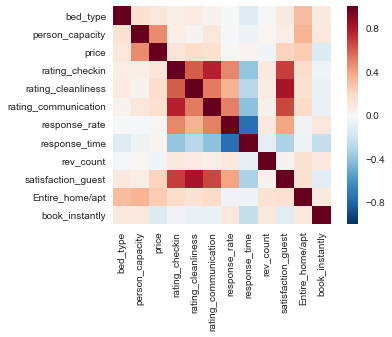

In [99]:
# Below we can see the Pearson's r correlation of the listings data. 
# Pearson's r measures the strength of the linear relationship between two variables.  
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
corr_matrix = tyo.corr()
sns.heatmap(corr_matrix, square=True)

In [100]:
X.head()

,accuracy,bed_type,person_capacity,rating_checkin,rating_cleanliness,rating_communication,response_rate,rev_count,satisfaction_guest,Entire_home/apt,book_instantly
1,9,1,16.0,9.0,8.0,10.0,1.0,25.0,87.0,1,1
3,9,1,5.0,10.0,9.0,10.0,1.0,19.0,96.0,1,1
5,9,1,8.0,10.0,10.0,10.0,1.0,23.0,97.0,1,1
7,10,1,6.0,10.0,10.0,10.0,1.0,123.0,98.0,1,1
9,10,1,2.0,10.0,10.0,10.0,1.0,5.0,100.0,1,1


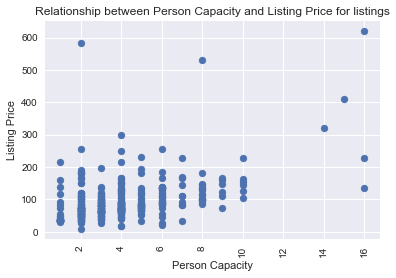

In [101]:
# I'm interested in seeing how person capacity correlates to the listing price. Let's graph it.
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.scatter(tyo.person_capacity,tyo.price)
plt.xlabel("Person Capacity")
plt.ylabel("Listing Price")
plt.title("Relationship between Person Capacity and Listing Price for listings")
plt.show()

In [102]:
# Show how many rows are 
X.isnull().sum().sort_values(ascending=False).head() 

satisfaction_guest      28
rating_communication    28
rating_cleanliness      28
rating_checkin          28
accuracy                28
dtype: int64

In [103]:
def show_best(grid_pipe):
    print(f'Best params: {grid_pipe.best_params_} \n\nBest score (MAE): {-1*grid_pipe.best_score_}')

In [104]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

In [105]:
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor

In [106]:

pipeline3 = Pipeline([
    ('imp', Imputer(missing_values='NaN', strategy = 'mean', axis=0)),
    ('rgr', GradientBoostingRegressor())
])

tuned_parameters = {
    "rgr__n_estimators":      [ n for n in range(80,200,10)],
    "rgr__max_depth" :        [ 3  ],
    "rgr__learning_rate":     [   0.1, .05, .15],
    "rgr__min_samples_split" :[  6    ],
    "rgr__loss" :             [ 'ls', 'lad' ],
    "rgr__max_features":      [ 1.0, 0.8,  0.5, 0.3   , 0.1    ]}

noScalePipe = GridSearchCV(pipeline3, tuned_parameters, cv=5, scoring='neg_median_absolute_error')
noScalePipe.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('rgr', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_sp...       presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'rgr__n_estimators': [80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190], 'rgr__max_depth': [3], 'rgr__learning_rate': [0.1, 0.05, 0.15], 'rgr__min_samples_split': [6], 'rgr__loss': ['ls', 'lad'], 'rgr__max_features': [1.0, 0.8, 0.5, 0.3, 0.1]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_median_absolute_error', verbose=0)

In [107]:
show_best(noScalePipe)

Best params: {'rgr__learning_rate': 0.1, 'rgr__loss': 'lad', 'rgr__max_depth': 3, 'rgr__max_features': 0.5, 'rgr__min_samples_split': 6, 'rgr__n_estimators': 160} 

Best score (MAE): 13.702675398151518


Now we instantiate the GBRegressor into a new pipeline so we can extract feature importances from it (scikit-learn deos not allow us to extract feature importances from a gridsearched pipeline). 

In [108]:
gbt = GradientBoostingRegressor(alpha=0.9, criterion = 'friedman_mse', init = None,
               learning_rate = 0.05, loss = 'lad', max_depth = 3, max_features = .5,
               max_leaf_nodes = None,
               min_impurity_split = None, min_samples_leaf = 1,
               min_samples_split = 6, min_weight_fraction_leaf = 0.0,
               n_estimators = 160, presort = 'auto', random_state=None,
               subsample = 1.0, verbose = 0, warm_start = False)
pipeline = Pipeline([
    ('imp', Imputer(missing_values='NaN', strategy = 'mean', axis=0)),
    ('rgr', gbt)
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('rgr', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='lad', max_depth=3, max_features=0.5,
             max_leaf_nodes=None, min_impurity_s...       presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False))])

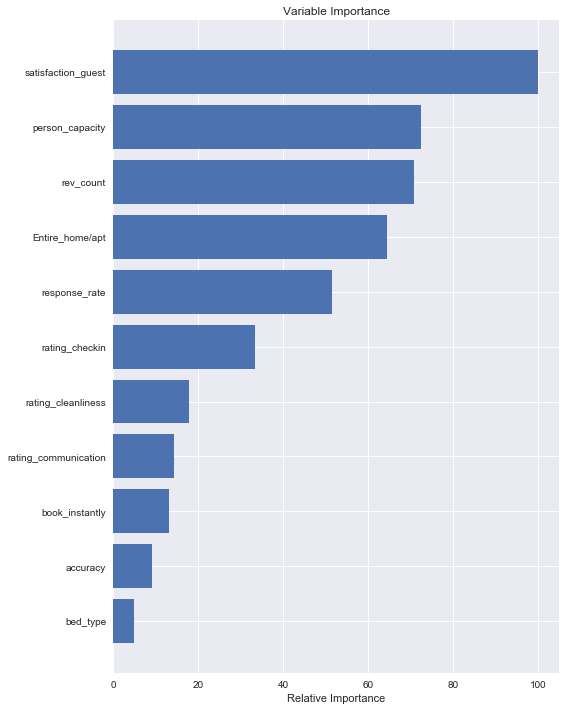

In [109]:
feature_importance = gbt.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
pvals = feature_importance[sorted_idx]
pcols = X_train.columns[sorted_idx]
plt.figure(figsize=(8,12))
plt.barh(pos, pvals, align='center')
plt.yticks(pos, pcols)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

#As expected, person capacity was the most important variable when predicting price

<li> We can see that the median absolute error was around $13 with the GBRegressor and the most important feature when it came to predicting price was the number of reviews of a listing. Now let's compare it to linear statistical models below.</li>

In [110]:
imp = Imputer(missing_values='NaN', strategy = 'median', axis=0)
imp.fit(X)
X = pd.DataFrame(data=imp.transform(X), columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)


[ 22.43590597  22.2955814   19.09626037  19.42072797  19.69915185
  23.7814173   19.81356453  19.62987255  19.09135322  22.43590597]


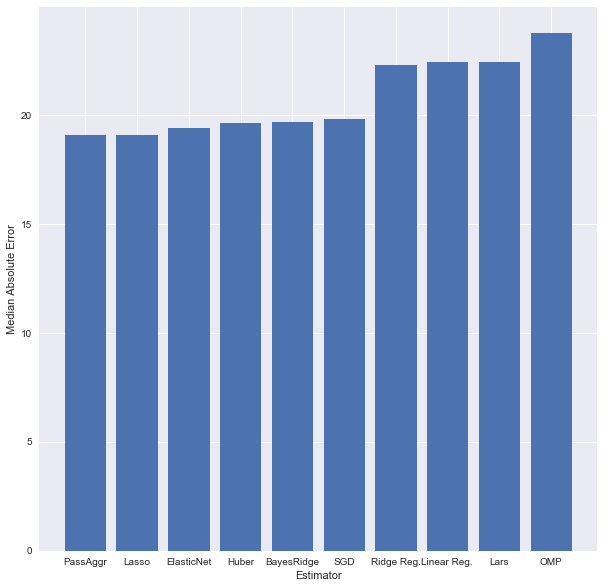

In [111]:
# get median error values using sklearn. 
# use matplotlib to graph the calculations
from sklearn import linear_model
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


%matplotlib inline

rs = 1

ests = [ linear_model.LinearRegression(), linear_model.Ridge(),
        linear_model.Lasso(), linear_model.ElasticNet(),
        linear_model.BayesianRidge(), linear_model.OrthogonalMatchingPursuit(), linear_model.SGDRegressor(),
       linear_model.HuberRegressor(), linear_model.PassiveAggressiveRegressor(), linear_model.Lars()]
ests_labels = np.array(['Linear Reg. ', 'Ridge Reg.', 'Lasso', 'ElasticNet', 'BayesRidge', 'OMP', 'SGD', 
                        'Huber', 'PassAggr', 'Lars'])
errvals = np.array([])


for e in ests:
    e.fit(X_train, y_train)
    this_err = metrics.median_absolute_error(y_test, e.predict(X_test))
    #print "got error %0.2f" % this_err
    errvals = np.append(errvals, this_err)

    
pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
plt.figure(figsize=(10,len(ests_labels)))
plt.bar(pos, errvals[srt], align='center')
plt.xticks(pos, ests_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')
print(errvals)

# calculate median error using gradient boosting regression


<li> The graph above shows that other untuned statistical estimators gave us a median absolute error rate of around 19 to 23 dollars. Gradient boosting achieved ~50% less error compared to traditional statistical models. </li>